In [1]:
import sys

In [2]:
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install regex

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from re import search

Preliminary Analysis

Importing the dataset

In [4]:
cwd = os.getcwd()
dataset_dir = os.path.join(cwd,'Dataset')
df = pd.read_csv(os.path.join(dataset_dir,'train_news.csv'))

In [5]:
print("Dataset shape:", df.shape)

Dataset shape: (20800, 6)


In [6]:
df.head()

,Unnamed: 0,id,headline,written_by,news,label
0,0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [7]:
unnamed_columns = [col for col in df.columns if search(r'^Unnamed', col)]

df = df.drop(unnamed_columns, axis=1)

df.head()

,id,headline,written_by,news,label
0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [8]:
print("Dataset shape:", df.shape)

Dataset shape: (20800, 5)


Cleaning the data

Checking for missing data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          20800 non-null  int64 
 1   headline    20242 non-null  object
 2   written_by  18843 non-null  object
 3   news        20761 non-null  object
 4   label       20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [10]:
print('Dataset null values:\n',df.isna().sum())

Dataset null values:
 id               0
headline       558
written_by    1957
news            39
label            0
dtype: int64


In [11]:
def show_tf_distribution(df, column) :
    null = df[df[column].isna()]
    total = len(null)
    notfake_cnt = list(null[null['label']==0].shape)[0]
    fake_cnt = list(null[null['label']==1].shape)[0]
    
    print('Null Values distribution for \''+column+'\' on basis for realness')
    print('Total:\t',total)
    print('Real %:\t',format(((notfake_cnt/total)*100),'.2f'))
    print('Fake %:\t',format(((fake_cnt/total)*100),'.2f'))

In [12]:
show_tf_distribution(df, 'news')

Null Values distribution for 'news' on basis for realness
Total:	 39
Real %:	 0.00
Fake %:	 100.00


In [13]:
show_tf_distribution(df, 'headline')

Null Values distribution for 'headline' on basis for realness
Total:	 558
Real %:	 0.00
Fake %:	 100.00


In [14]:
show_tf_distribution(df, 'written_by')

Null Values distribution for 'written_by' on basis for realness
Total:	 1957
Real %:	 1.33
Fake %:	 98.67


As every instance of missing value almost always indicates a fake news article, missing value/information can be an identifying factor. Hence not dropping rows with null values.

Checking for placeholder values and duplicates

In [15]:
headline_value_counts = df.headline.value_counts()
headline_value_counts[headline_value_counts > 1]

The Dark Agenda Behind Globalism And Open Borders                                                                            5
Get Ready For Civil Unrest: Survey Finds That Most Americans Are Concerned About Election Violence                           5
The Fix Is In: NBC Affiliate Accidentally Posts Election Results A Week Early: Hillary Wins Presidency 42% to Trump’s 40%    4
Schools All Over America Are Closing On Election Day Due To Fears Of Violence                                                4
Will Barack Obama Delay Or Suspend The Election If Hillary Is Forced Out By The New FBI Email Investigation?                 4
                                                                                                                            ..
War Less Imminent After Clinton Defeat                                                                                       2
115 Million Americans Killed In 30 Minutes                                                                     

In [16]:
duplicate_headline_list = set(headline_value_counts[headline_value_counts > 1].keys())
df_dup_headline = df[df.headline.isin(duplicate_headline_list)]
df_dup_headline

,id,headline,written_by,news,label
17,4694,Millions of South Koreans Rise Up Against Shad...,Madeline,Your News Wire \nSouth Koreans are rising up i...,1
47,11814,Las imágenes libres de derechos más destacadas...,Tomás Fuentes,Las imágenes libres de derechos más destacadas...,1
66,14678,Young patient,-NO AUTHOR-,Anatomy lesson Published: 12 mins ago \nEditor...,1
79,17351,Thomas Frank Explores Whether Hillary Clinton ...,NaN,,1
84,12395,Russia is Hoarding Gold at an Alarming Rate — ...,Jay Syrmopoulos,Home / Be The Change / Antiwar / Russia is Hoa...,1
...,...,...,...,...,...
20633,10988,WHO cancer agency under fire for withholding ‘...,Editor,The International Agency for Research on Cance...,1
20677,18176,"Rigged Primary, Media, and Candidate; the Amer...",NaN,Email \n\nThe excitement over the US election ...,1
20717,20652,Jeddah airport was targeted by Ansar Allah mis...,NaN,Email \n\nAn informed source in Yemen's AnsarA...,1
20753,9516,Las imágenes libres de derechos más destacadas...,Tomás Fuentes,Las imágenes libres de derechos más destacadas...,1


In [17]:
df_dup_headline[df_dup_headline.duplicated()]

,id,headline,written_by,news,label


There are no directly duplicated rows

In [18]:
df_dup_headline[df_dup_headline.duplicated(['headline', 'news'])]

,id,headline,written_by,news,label
1818,7178,JASON CHAFFETZ EXPOSED HILLARY CLINTON’S PLAN ...,NaN,The Corruption of the Clinton’s is like an end...,1
5016,3244,"The U.S./Turkey Plan For “Seizing, Holding, An...",Brandon Turbeville,By Brandon Turbeville As the U.S. Presidential...,1
5110,11407,19 men cry rape by Iran's top Quran reader,Jay Baggett,"Print Saeed Toosi, right, and Ayatollah Khamen...",1
5284,14974,North Korea Threatens ‘Sacred’ Nuclear War Aga...,NaN,Email \nNorth Korea’s Foreign Ministry slammed...,1
5390,15872,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",NaN,Email \n\nIt appears Bill and Hillary Clinton ...,1
...,...,...,...,...,...
19953,12925,War Less Imminent After Clinton Defeat,Glen Ford,2016 presidential campaign A Black Agenda Radi...,1
20385,15010,Donald J. Trump’s 10 Point Plan to Put America...,Anonymous,Tweet Widget by Tanya Golash-Boza \nHow will D...,1
20580,6111,Rand Paul: Polls Showing Hillary Ahead Are ‘De...,NaN,Email \n\nWednesday on 800 WVHU radio’s “The T...,1
20677,18176,"Rigged Primary, Media, and Candidate; the Amer...",NaN,Email \n\nThe excitement over the US election ...,1


There are 70 rows with both headlines and news duplicated. These needs to be removed.

In [19]:
df_dup_headline[df_dup_headline.news == ' ']

,id,headline,written_by,news,label
79,17351,Thomas Frank Explores Whether Hillary Clinton ...,NaN,,1
11572,5101,More on Trump’s Populism and How It Can Be Con...,Daily Bell Staff,,1
15286,20141,Thomas Frank Explores Whether Hillary Clinton ...,NaN,,1
17458,1591,More on Trump’s Populism and How It Can Be Con...,Daily Bell Staff,,1


We can leave duplicate headlines as that is a common part of news when it undergoes revision but those instances where both headline and news articles are same needs to be dropped. Rows without news will also be removed.

Checking news for whitespaces.

In [20]:
df[df.news == ' ']

,id,headline,written_by,news,label
79,17351,Thomas Frank Explores Whether Hillary Clinton ...,NaN,,1
210,936,Hillary is Sick & Tired of Suffering from Wein...,Captain Craptek,,1
271,295,A Connecticut Reader Reports Record Voter Regi...,VDARE.com Reader,,1
472,16561,Not sure what to do with your time now Bake Of...,newsbiscuit editorial team,,1
1573,16715,Citizens Reject Forced Diversity Policy by Sup...,Brenda Walker,,1
...,...,...,...,...,...
19880,4275,"Yes, Virginia (Dare), There ARE Righteous Jews...",Paul Gottfried,,1
20232,16347,Trump’s Closing Argument,Steve Sailer,,1
20543,592,Is your promising internet career over now Vin...,newsbiscuit editorial team,,1
20559,2228,YIKES! HILLARY GOES OFF THE RAILS…Pulls A Howa...,EdJenner,,1


Replacing white spaces with null.

In [21]:
df = df.replace(r'^\s*$', np.nan, regex=True)

In [22]:
df.isna().sum()

id               0
headline       558
written_by    1957
news           116
label            0
dtype: int64

This shows that there is increase in null values in column news as we replace articles that only had null values.

In [23]:
show_tf_distribution(df, 'news')

Null Values distribution for 'news' on basis for realness
Total:	 116
Real %:	 0.00
Fake %:	 100.00


The distribution shows that all null news values still point to fake news. As these values are small compared to total dataset size, dropping them might be preferable.

Removing Duplicated Data

In [24]:
len(df)

20800

Dropping rows with no news article or headlines

In [25]:
df_clean = df.dropna(subset=['headline','news'])

In [26]:
len(df_clean)

20126

Dropping rows with same headline and news articles

In [27]:
df_clean = df_clean.drop_duplicates(['headline', 'news'], ignore_index=True)

In [28]:
len(df_clean)

20058

Dropping rows with same news articles

In [29]:
df_clean = df_clean.drop_duplicates(['news'], ignore_index=True)

In [30]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19865 entries, 0 to 19864
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          19865 non-null  int64 
 1   headline    19865 non-null  object
 2   written_by  18013 non-null  object
 3   news        19865 non-null  object
 4   label       19865 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 776.1+ KB


In [31]:
df_clean.isna().sum()

id               0
headline         0
written_by    1852
news             0
label            0
dtype: int64

In [32]:
len(df) - len(df_clean)

935

In [33]:
df_clean.label.value_counts()

0    10387
1     9478
Name: label, dtype: int64

Summary

935 rows of data removed on basis of not having information in news column, headline column and or having duplicate values.

Exploring the dataset

Helper Function

In [34]:
graph_dir = os.path.join(cwd,'Graphs')

In [35]:
def show_hist_for_col(df, column, title):
    """
    Display a histogram for a column in a dataframe, splitting the data by label.
    """
    plt.figure(figsize=(12,8))
    df[df.label == 0][column].hist(label='True')
    df[df.label == 1][column].hist(alpha=0.4, label='Fake')
    plt.title(title)
    plt.legend()
    plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
    plt.show()
    plt.close()

Distribution of Labels

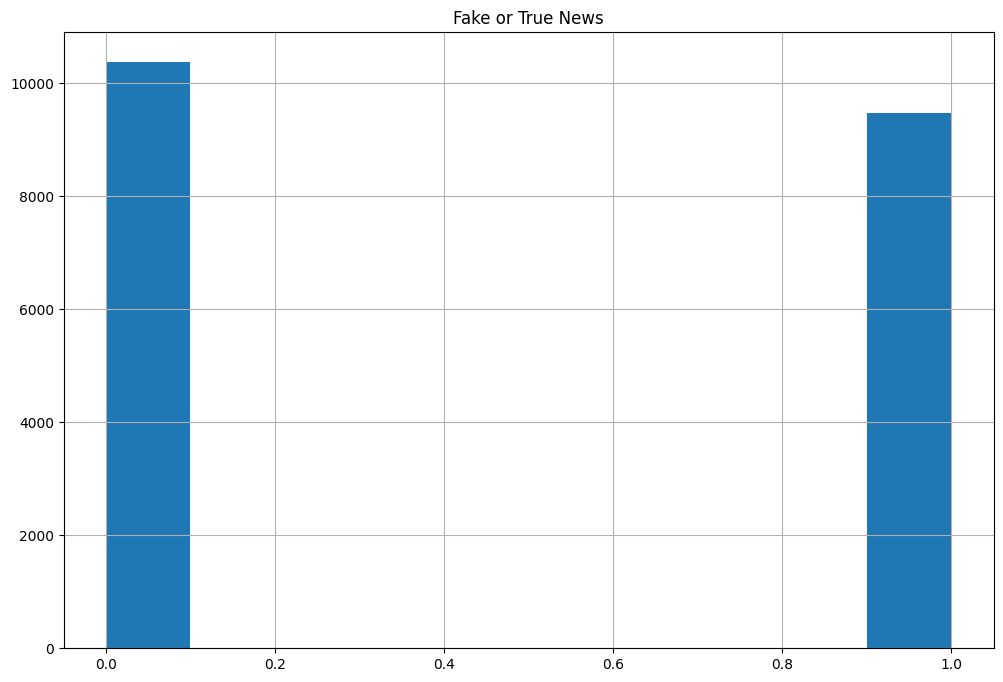

In [36]:
plt.figure(figsize=(12,8))
df_clean.label.hist()
title = 'Fake or True News'
plt.title(title)
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

After cleaning the data there is an imbalance present but hopefully not enough to have effect on the models

Length of Headlines

In [37]:
df_clean['headline_len'] = df_clean.headline.str.len()

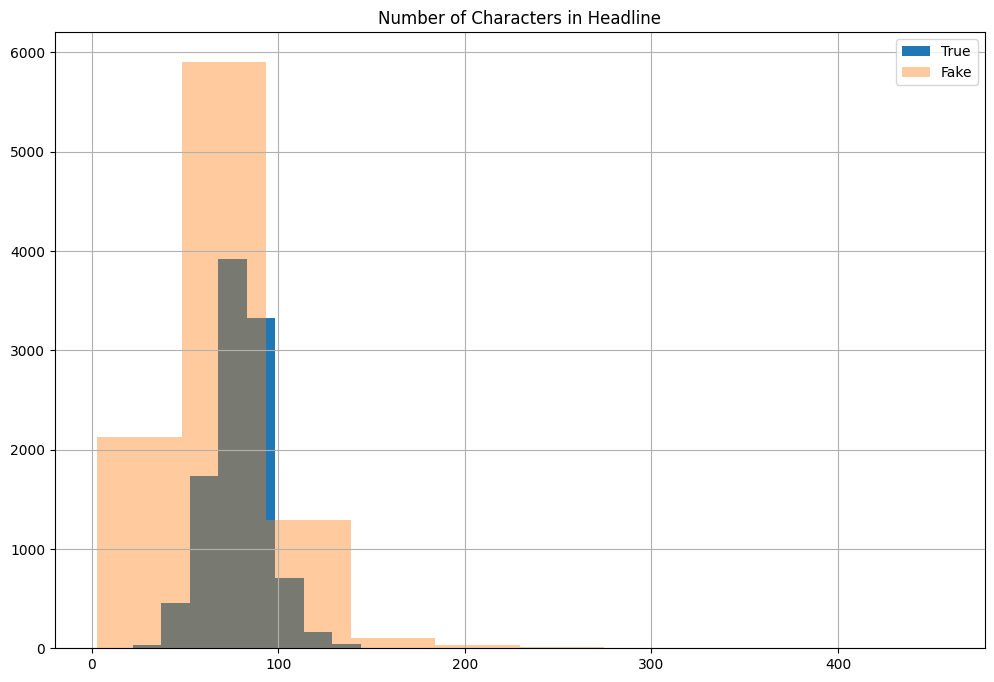

In [38]:
show_hist_for_col(df_clean, 'headline_len', 'Number of Characters in Headline')

In [39]:
df_clean[df_clean.label == 0].headline_len.describe()

count    10387.000000
mean        79.594974
std         15.568225
min         22.000000
25%         70.000000
50%         81.000000
75%         89.000000
max        175.000000
Name: headline_len, dtype: float64

In [40]:
df_clean[df_clean.label == 1].headline_len.describe()

count    9478.000000
mean       68.609200
std        27.971262
min         3.000000
25%        50.000000
50%        67.000000
75%        83.000000
max       456.000000
Name: headline_len, dtype: float64

Fake news stories have a wider range in the length of title than True news stories. The quartile differences between fake news articles is much larger than in case of true news article.

Length of News article

In [41]:
df_clean['news_len'] = df_clean.news.str.len()

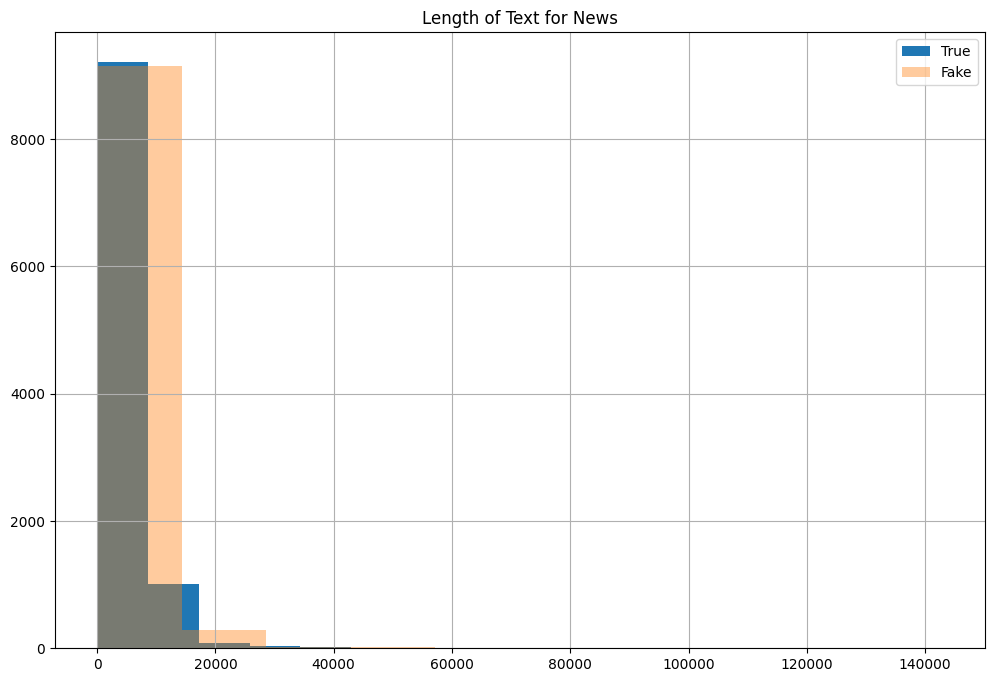

In [42]:
show_hist_for_col(df_clean, 'news_len', 'Length of Text for News')

In [43]:
df_clean[df_clean.label == 0].news_len.describe()

count    10387.000000
mean      5214.130452
std       4313.791236
min          3.000000
25%       2397.000000
50%       4591.000000
75%       7015.000000
max      85948.000000
Name: news_len, dtype: float64

In [44]:
df_clean[df_clean.label == 1].news_len.describe()

count      9478.000000
mean       4134.509285
std        5858.338319
min           9.000000
25%        1253.250000
50%        2589.000000
75%        5081.000000
max      142961.000000
Name: news_len, dtype: float64

In [45]:
df_long = df_clean[df_clean.news_len > 10000]

In [46]:
df_long

,id,headline,written_by,news,label,headline_len,news_len
5,3196,Whatever the Outcome on November 8th the US Wi...,NaN,Taming the corporate media beast Whatever the ...,1,106,15285
52,880,How the Iranian-Saudi Proxy Struggle Tore Apar...,Max Fisher,Behind much of the Middle East’s chaos — th...,0,84,11755
58,6845,WikiLeaks Releases Trove of Alleged C.I.A. Hac...,"Scott Shane, Matthew Rosenberg and Andrew W. L...",WASHINGTON — In what appears to be the larg...,0,81,10455
63,19180,Police Depts. Paid AT&T Millions To Scrutinize...,Edmondo Burr,"Edmondo Burr in News , US // 0 Comments Adam...",1,69,10786
67,13734,"Decades Later, Sickness Among Airmen After a H...",Dave Philipps,Alarms sounded on United States Air Force base...,0,88,26860
...,...,...,...,...,...,...,...
19801,9392,When Solar Panels Became Job Killers - The New...,Keith Bradsher,"WUHAN, China — Russell Abney raised two chi...",0,57,12783
19832,491,‘They Will Have to Die Now’ - The New York Times,James Verini,"Before dawn on a Sunday late last month, a bat...",0,48,27714
19849,3629,Awakened Humanity Awaits Fully Scripted Ending...,noreply@blogger.com (Alexander Light),. Awakened Humanity Awaits Fully Scripted Endi...,1,62,10650
19852,9792,The Lost Footage of Marilyn Monroe - The New Y...,Helene Stapinski,It happened one night in the late summer of 19...,0,55,15332


In [47]:
df_long.label.value_counts()

1    707
0    647
Name: label, dtype: int64

ok there does not seem to be bias in long stories towards either type of articles so they will be kept. also fake news article have shown much higher max story size and significantly lower quartile scores across the board.

Capital letters in headline.

In [48]:
df_clean['caps_in_headline'] = df_clean['headline'].apply(lambda headline: sum(1 for char in headline if char.isupper()))

In [49]:
df_clean

,id,headline,written_by,news,label,headline_len,news_len,caps_in_headline
0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,84,7936,11
1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,72,6112,13
2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0,100,425,12
3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,100,6516,15
4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1,28,9164,5
...,...,...,...,...,...,...,...,...
19860,366,One Police Shift: Patrolling an Anxious Americ...,The New York Times,Policing in America today is a rib dinner paid...,0,68,19894,10
19861,14831,Albert Pike and the European Migrant Crisis,Rixon Stewart,"By Rixon Stewart on November 5, 2016 Rixon Ste...",1,43,6621,5
19862,18142,Dakota Access Caught Infiltrating Protests to ...,Eddy Lavine,posted by Eddie You know the Dakota Access Pip...,1,84,3433,10
19863,12139,How to Stretch the Summer Solstice - The New Y...,Alison S. Cohn,"It’s officially summer, and the Society Boutiq...",0,55,2334,8


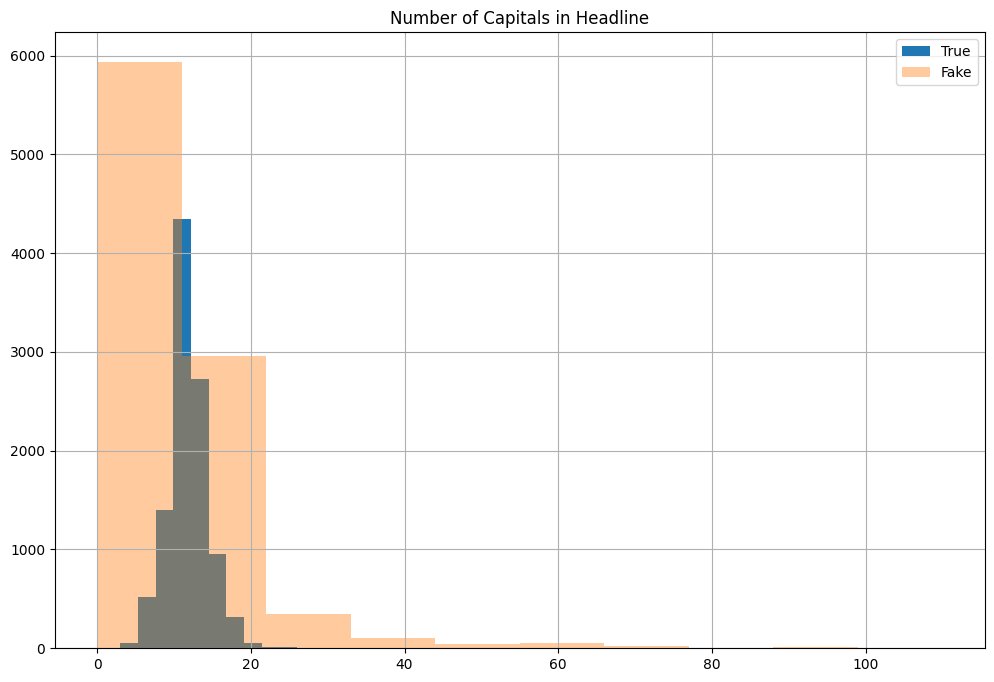

In [50]:
show_hist_for_col(df_clean, 'caps_in_headline', 'Number of Capitals in Headline')

In [51]:
df_clean[df_clean.label == 0].caps_in_headline.describe()

count    10387.000000
mean        11.809088
std          2.676369
min          3.000000
25%         10.000000
50%         12.000000
75%         13.000000
max         26.000000
Name: caps_in_headline, dtype: float64

In [52]:
df_clean[df_clean.label == 1].caps_in_headline.describe()

count    9478.000000
mean       10.285714
std         9.065833
min         0.000000
25%         5.000000
50%         9.000000
75%        13.000000
max       110.000000
Name: caps_in_headline, dtype: float64

There is much more deviation in number of Capital letter in headline in fake news articles. also fake news articles have much more amount of Capital letter in headline.

In [53]:
df_clean['norm_caps_in_headline'] = df_clean['caps_in_headline'] / df_clean['headline_len']

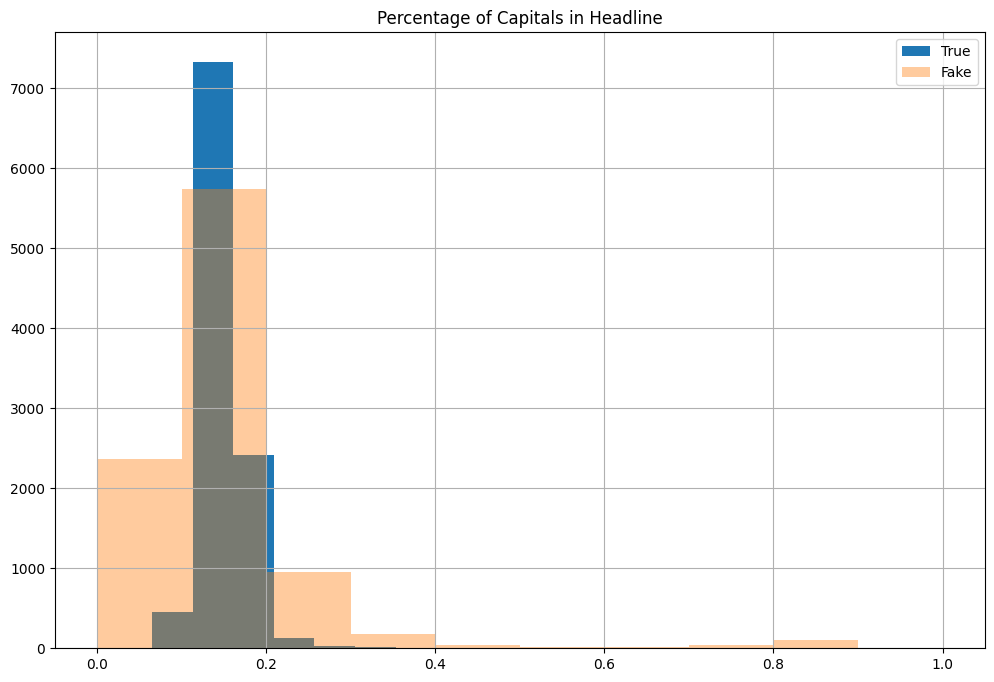

In [54]:
show_hist_for_col(df_clean, 'norm_caps_in_headline', 'Percentage of Capitals in Headline')

In [55]:
df_clean[df_clean.label == 0].norm_caps_in_headline.describe()

count    10387.000000
mean         0.149200
std          0.024251
min          0.064815
25%          0.134328
50%          0.147727
75%          0.160920
max          0.545455
Name: norm_caps_in_headline, dtype: float64

In [56]:
df_clean[df_clean.label == 1].norm_caps_in_headline.describe()

count    9478.000000
mean        0.149706
std         0.112392
min         0.000000
25%         0.100000
50%         0.139010
75%         0.173077
max         1.000000
Name: norm_caps_in_headline, dtype: float64

percentage of capitals is not good enough as the values is quite close between fake and true news headlines.

Capital in news article

In [57]:
df_clean['caps_in_news'] = df_clean['news'].apply(lambda news: sum(1 for char in news if char.isupper()))

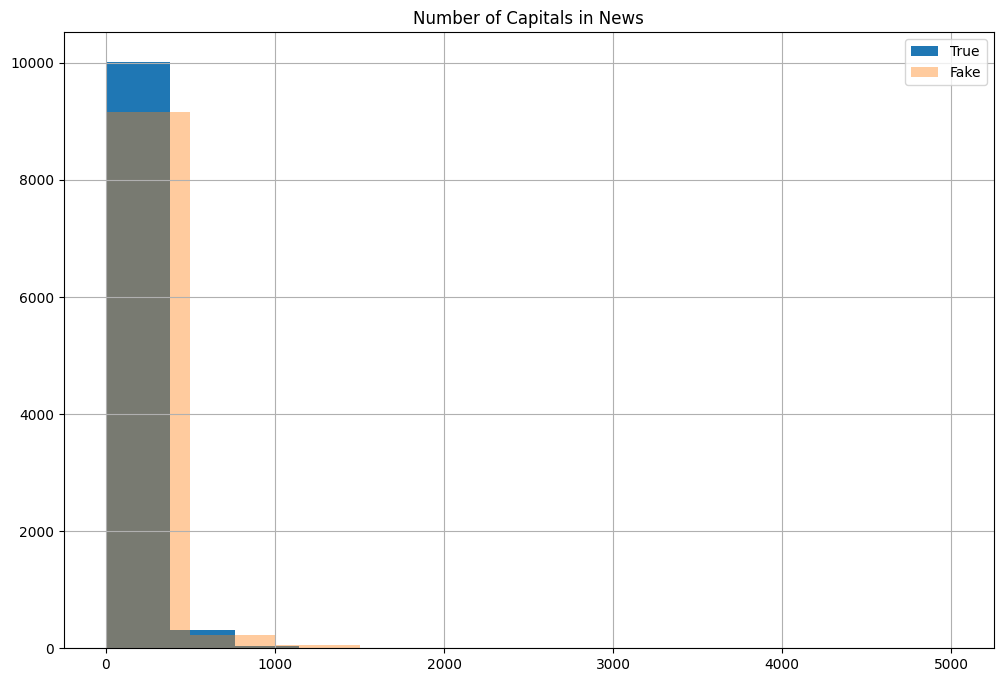

In [58]:
show_hist_for_col(df_clean, 'caps_in_news', 'Number of Capitals in News')

In [59]:
df_clean[df_clean.label == 0].caps_in_news.describe()

count    10387.000000
mean       159.919130
std        134.498051
min          0.000000
25%         79.000000
50%        136.000000
75%        206.000000
max       3809.000000
Name: caps_in_news, dtype: float64

In [60]:
df_clean[df_clean.label == 1].caps_in_news.describe()

count    9478.000000
mean      146.040937
std       210.724968
min         0.000000
25%        49.250000
50%        95.000000
75%       173.000000
max      5000.000000
Name: caps_in_news, dtype: float64

In [61]:
df_clean['norm_caps_in_news'] = df_clean['caps_in_news'] / df_clean['news_len']

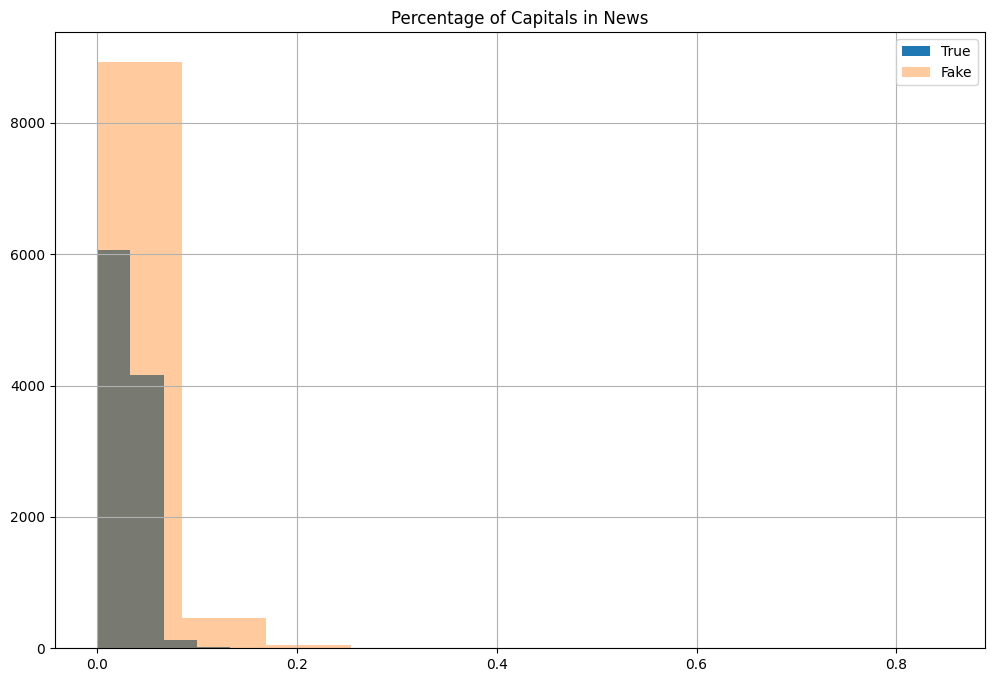

In [62]:
show_hist_for_col(df_clean, 'norm_caps_in_news', 'Percentage of Capitals in News')

In [63]:
df_clean[df_clean.label == 0].norm_caps_in_news.describe()

count    10387.000000
mean         0.033159
std          0.011551
min          0.000000
25%          0.026081
50%          0.031427
75%          0.037752
max          0.333333
Name: norm_caps_in_news, dtype: float64

In [64]:
df_clean[df_clean.label == 1].norm_caps_in_news.describe()

count    9478.000000
mean        0.043653
std         0.038608
min         0.000000
25%         0.027862
50%         0.036180
75%         0.047848
max         0.846154
Name: norm_caps_in_news, dtype: float64

Once again there is a lot of overlap in number of capitals in news article between fake and real news. only in third quartile do fake news show much more amount of capitals in fake news articles.

In [65]:
def check_string_for(substring, fullstring):
    """Check if the substring is in the fullstring"""
    if search(substring, fullstring):
        return True
    else:
        return False

Via and Image Via in article

In [66]:
df_via = df_clean[df_clean.news.apply(lambda news_text: check_string_for(' via', news_text))]

In [67]:
df_via

,id,headline,written_by,news,label,headline_len,news_len,caps_in_headline,norm_caps_in_headline,caps_in_news,norm_caps_in_news
23,1155,Exclusive — Sarah Palin on Paul Ryan’s ‘RINO-C...,Matthew Boyle,"Former Alaska Gov. Sarah Palin, the 2008 Repub...",0,115,9455,19,0.165217,291,0.030777
53,16954,‘Silicon Valley’ Season 3 Episode 6: Spaces vs...,Scott Tobias,For a show about a bunch of single dudes in th...,0,73,5494,10,0.136986,138,0.025118
64,16279,Anti-Abortion Group Presses Ahead Despite Rece...,Erik Eckholm,"HERNDON, Va. — Stung by the recent Supreme ...",0,90,7465,14,0.155556,147,0.019692
66,2435,Someone Made a Guide for What To Do If You See...,Tom Cahill,"Tom Cahill | November 11, 2016 \nA brilliant g...",1,59,2381,12,0.203390,44,0.018480
77,451,The Jobs Americans Do - The New York Times,Binyamin Appelbaum,Forget the images of men in hard hats standing...,0,42,34313,8,0.190476,864,0.025180
...,...,...,...,...,...,...,...,...,...,...,...
19823,13182,"FBI Found ""Tens Of Thousands Of Emails"" Belong...",NaN,"FBI Found ""Tens Of Thousands Of Emails"" Belong...",1,83,4650,16,0.192771,177,0.038065
19824,12879,Wikileaks Director Gavin MacFadyen Dead,Tim Brown,9 News reports : \nIt is understood the Americ...,1,39,3270,6,0.153846,91,0.027829
19845,3610,Paul Ryan’s Plan To Use Bernie To Scare Voters...,Michael Hayne,"By Michael Hayne Election 2016 , News , Politi...",1,97,2238,19,0.195876,119,0.053172
19849,3629,Awakened Humanity Awaits Fully Scripted Ending...,noreply@blogger.com (Alexander Light),. Awakened Humanity Awaits Fully Scripted Endi...,1,62,10650,7,0.112903,215,0.020188


In [68]:
df_via['label'].value_counts()

1    843
0    509
Name: label, dtype: int64

Via is much more indicative of fake news article compared to true news article.

In [69]:
df_image_via = df_clean[df_clean.news.apply(lambda news_text: check_string_for('image via', news_text))]

In [70]:
df_image_via

,id,headline,written_by,news,label,headline_len,news_len,caps_in_headline,norm_caps_in_headline,caps_in_news,norm_caps_in_news
98,5144,Trump Gets Dumped On Instagram By Supermodel G...,Blanche Benson,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,68,2424,14,0.205882,124,0.051155
342,10311,BOMBSHELL: Justice Clarence Thomas Accused Of ...,Karen Shiebler,BOMBSHELL: Justice Clarence Thomas Accused Of ...,1,71,2585,21,0.295775,125,0.048356
354,13955,Comment on WATCH: Human Rights Activists Are T...,information security architect,WATCH: Human Rights Activists Are Targeting Th...,1,116,4370,16,0.137931,106,0.024256
908,13532,Rally Of Deplorables Call For Clinton Assassin...,Blanche Benson,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,97,1823,17,0.175258,79,0.043335
1670,18868,BREAKING: Melania Trump’s Immigration Records ...,NaN,"on November 4, 2016 10:58 pm · \nGOP president...",1,133,3562,31,0.233083,98,0.027513
...,...,...,...,...,...,...,...,...,...,...,...
19537,9135,Most Embarrassing Mom Liz Cheney Dresses Daugh...,Jameson Parker,\nIt was recently noted that superhero costu...,1,97,2450,19,0.195876,71,0.028980
19616,15423,CNN’s Van Jones Has Some Reality For Trump: If...,Allison Vincent,"By Allison Vincent Election 2016 , News , Poli...",1,91,1596,24,0.263736,104,0.065163
19678,9983,BREAKING: Miami Woman BUSTED On Election Fraud...,Karen Shiebler,BREAKING: Miami Woman BUSTED On Election Fraud...,1,80,2889,24,0.300000,105,0.036345
19699,5668,BREAKING: AP Finds Proof Melania Trump Illegal...,Jameson Parker,\nIn what may be the last bombshell to drop ...,1,90,2538,28,0.311111,64,0.025217


In [71]:
df_image_via['label'].value_counts()

1    90
Name: label, dtype: int64

With all the posts with image via being Fake, it's highly indicative of that label, but this may be particular to this dataset and may not generalize.

Said in news article

In [72]:
df_said = df_clean[df_clean.news.apply(lambda news_text: check_string_for('said', news_text))]

In [73]:
df_said

,id,headline,written_by,news,label,headline_len,news_len,caps_in_headline,norm_caps_in_headline,caps_in_news,norm_caps_in_news
0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,84,7936,11,0.130952,227,0.028604
1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,72,6112,13,0.180556,256,0.041885
3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,100,6516,15,0.150000,196,0.030080
5,3196,Whatever the Outcome on November 8th the US Wi...,NaN,Taming the corporate media beast Whatever the ...,1,106,15285,13,0.122642,465,0.030422
6,5134,Rapid Evolution Saved This Fish From Pollution...,JoAnna Klein,The State of New Jersey says you can’t eat the...,0,79,4159,13,0.164557,79,0.018995
...,...,...,...,...,...,...,...,...,...,...,...
19856,4857,A Suburban Experiment Aims for Free Energy - T...,Diane Cardwell,"FONTANA, Calif. — At first glance, Anthony ...",0,63,6974,10,0.158730,126,0.018067
19857,5895,"Putin: No difference between Clinton, Trump",Editor,Russian President Vladimir Putin has responded...,1,43,2209,4,0.093023,82,0.037121
19858,7244,"REUTERS TO CUT 2,000 JOBS…",newsguy76,Warning : array_key_exists() expects parameter...,1,26,1922,16,0.615385,79,0.041103
19859,16132,"Assad’s History of Chemical Attacks, and Other...",Russell Goldman,"In six years of war, President Bashar of Syr...",0,78,3850,10,0.128205,86,0.022338


In [74]:
df_said['label'].value_counts()

0    8670
1    4110
Name: label, dtype: int64

The stories containing the word said are indicative of the news story being true. With twice as many of the "true" news stories containing said vs. "fake", the true ones must seem likely to be more concerned with providing quotations, or at least quotations in this style.

On in news article

In [75]:
df_on = df_clean[df_clean.news.apply(lambda news_text: check_string_for(' on ', news_text))]

In [76]:
df_on

,id,headline,written_by,news,label,headline_len,news_len,caps_in_headline,norm_caps_in_headline,caps_in_news,norm_caps_in_news
0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,84,7936,11,0.130952,227,0.028604
1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,72,6112,13,0.180556,256,0.041885
2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0,100,425,12,0.120000,28,0.065882
3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,100,6516,15,0.150000,196,0.030080
4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1,28,9164,5,0.178571,309,0.033719
...,...,...,...,...,...,...,...,...,...,...,...
19860,366,One Police Shift: Patrolling an Anxious Americ...,The New York Times,Policing in America today is a rib dinner paid...,0,68,19894,10,0.147059,513,0.025787
19861,14831,Albert Pike and the European Migrant Crisis,Rixon Stewart,"By Rixon Stewart on November 5, 2016 Rixon Ste...",1,43,6621,5,0.116279,212,0.032019
19862,18142,Dakota Access Caught Infiltrating Protests to ...,Eddy Lavine,posted by Eddie You know the Dakota Access Pip...,1,84,3433,10,0.119048,151,0.043985
19863,12139,How to Stretch the Summer Solstice - The New Y...,Alison S. Cohn,"It’s officially summer, and the Society Boutiq...",0,55,2334,8,0.145455,91,0.038989


In [77]:
df_on.label.value_counts()

0    10177
1     7709
Name: label, dtype: int64

The use of 'on' is fairly balanced although somewhat indicative of a 'true' story.

You in news article

In [78]:
df_you = df_clean[df_clean.news.apply(lambda news_text: check_string_for(' you ', news_text))]

In [79]:
df_you

,id,headline,written_by,news,label,headline_len,news_len,caps_in_headline,norm_caps_in_headline,caps_in_news,norm_caps_in_news
0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,84,7936,11,0.130952,227,0.028604
1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,72,6112,13,0.180556,256,0.041885
3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,100,6516,15,0.150000,196,0.030080
6,5134,Rapid Evolution Saved This Fish From Pollution...,JoAnna Klein,The State of New Jersey says you can’t eat the...,0,79,4159,13,0.164557,79,0.018995
7,1504,Alabama Prison Officials Retaliate Against Pri...,Brian Sonenstein,Advocates say prison officials at the Kilby Co...,1,88,6311,13,0.147727,224,0.035494
...,...,...,...,...,...,...,...,...,...,...,...
19854,12386,Comment on Texas Police Arrest Trump Voter for...,Terry,"Posted on October 30, 2016 by Tim Brown \nOn M...",1,84,4440,11,0.130952,149,0.033559
19856,4857,A Suburban Experiment Aims for Free Energy - T...,Diane Cardwell,"FONTANA, Calif. — At first glance, Anthony ...",0,63,6974,10,0.158730,126,0.018067
19857,5895,"Putin: No difference between Clinton, Trump",Editor,Russian President Vladimir Putin has responded...,1,43,2209,4,0.093023,82,0.037121
19860,366,One Police Shift: Patrolling an Anxious Americ...,The New York Times,Policing in America today is a rib dinner paid...,0,68,19894,10,0.147059,513,0.025787


In [80]:
df_you.label.value_counts()

0    4844
1    4123
Name: label, dtype: int64

You is equally present in both true and fake news stories.

Save the Cleaned Dataset

In [81]:
df_clean.to_csv(os.path.join(dataset_dir,'train_news_cleaned.csv'),index=False)